In [1]:
import torch
from torch.utils.data import Dataset
from scipy.io import loadmat
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class MyData(Dataset):

    def __init__(self, training_set_dir, training_label_dir):
        self.training_set_dir = training_set_dir
        self.training_label_dir = training_label_dir
        self.name = os.listdir(self.training_set_dir)
        self.name = sorted(self.name)

    def __getitem__(self, idx):
        data_name = self.name[idx]
        data_item_path = os.path.join(self.training_set_dir, data_name)
        self.imgs = loadmat(data_item_path)
        self.imgs = self.imgs["ECG"][0][0][2]
        if self.imgs.shape[1] < 10000:
            pad_length = 10000 - self.imgs.shape[1]
            self.imgs = np.pad(self.imgs, ((0, 0), (0, pad_length)), mode='constant', constant_values=0)
        else:
            self.imgs = self.imgs[:, 0:10000]
        df = pd.read_csv(self.training_label_dir)
        labels = df.loc[idx, "First_label"]
        self.imgs = torch.from_numpy(self.imgs)
        self.imgs = self.imgs.float()
        labels = torch.tensor(labels)-1
        labels = labels.long()
        return self.imgs, labels

    def __len__(self):
        return len(self.name)


torch.Size([12, 10000])
tensor(7)


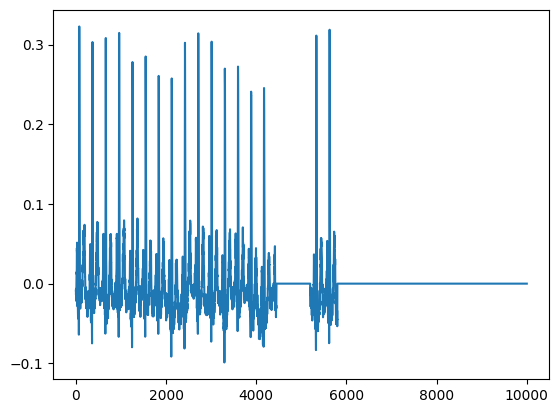

In [2]:
import torch
from scipy.interpolate import interp1d
from torch.utils.data import Dataset
from scipy.io import loadmat
import os
import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn

class TrainData(Dataset):

    def __init__(self, training_set_dir, training_label_dir):
        self.training_set_dir = training_set_dir
        self.training_label_dir = training_label_dir
        self.name = os.listdir(self.training_set_dir)
        self.name = sorted(self.name)
        self.mask = Mask()
        self.scale = Scale()
    def __getitem__(self, idx):
        data_name = self.name[idx]
        data_item_path = os.path.join(self.training_set_dir, data_name)
        self.imgs = loadmat(data_item_path)
        self.imgs = self.imgs["ECG"][0][0][2]
        if self.imgs.shape[1] < 10000:
            pad_length = 10000 - self.imgs.shape[1]
            self.imgs = np.pad(self.imgs, ((0, 0), (0, pad_length)), mode='constant', constant_values=0)
        else:
            self.imgs = self.imgs[:, 0:10000]
        df = pd.read_csv(self.training_label_dir)
        labels = df.loc[idx, "First_label"]
        self.imgs = torch.from_numpy(self.imgs)
        self.imgs = self.scale(self.imgs)
        self.imgs = self.mask(self.imgs)
        self.imgs = self.imgs.float()
        labels = torch.tensor(labels)-1
        labels = labels.long()
        return self.imgs, labels

    def __len__(self):
        return len(self.name)

#数据增强，随机掩码
class Mask(object):

    def __init__(self, p=1.1):
        self.p = p
    def __call__(self, data):
        if random.uniform(0, 1) < self.p:
            mask = torch.zeros((12, 750))
            a = round(random.uniform(0, 9250))
            b = a+750
            data[:, a:b] = mask
            return data
        else:
            return data

#数据增强，随机放缩
class Scale(object):

    def __init__(self, p=1.1):
        self.p = p

    def __call__(self, data):
        global scale_data
        t_scale = random.uniform(1, 1.2)
        if random.uniform(0, 1) < self.p:
            C, L = data.shape
            L_scale = int(L * t_scale)
            scale_data = np.zeros([12, L_scale])
            for i in range(C):
                signal=data[i, :].numpy()
                original_indices = np.arange(L)
                new_indices = np.linspace(0, L-1, L_scale, dtype=int)
                f = interp1d(original_indices, signal)
                resampled_signal_precise = f(new_indices.astype(float))
                scale_data[i, :] = resampled_signal_precise
            scale_data_tensor = torch.from_numpy(scale_data)
            return scale_data_tensor[:, 0:10000]
        else:
            return data

if __name__ == "__main__":
    # training_set_dir = "D:\ECG\\training_set"
    # training_label_dir = "D:\ECG\\training_label\\training_label.csv"
    # dataset = MyData(training_set_dir, training_label_dir)
    testing_set_dir = "training_set"
    testing_label_dir = "training_label.csv"
    dataset = TrainData(testing_set_dir, testing_label_dir)
    data, label = dataset[0]
    print(data.shape)
    print(label)
    plt.plot(data[0, :])
    plt.show()

In [3]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def validate(model, val_loader, criterion, device):
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # 不需要计算梯度
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # 获取模型输出
            loss = criterion(outputs, labels)  # 计算损失
            val_loss += loss.item()  # 累积损失
            _, predicted = torch.max(outputs, 1)  # 获取预测类别
            total += labels.size(0)  # 累积样本数量
            correct += (predicted == labels).sum().item()  # 累积正确预测的样本数量
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # 计算平均损失
    avg_loss = val_loss / len(val_loader)

    # 计算准确率
    accuracy = 100 * correct / total

    # 计算查准率、查全率和F1-score
    avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                               average='macro')  # 或 'micro', 'weighted'
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    # 你可以打印或返回这些值
    for i in range(len(f1)):
        print(f'Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}')
    return avg_loss, accuracy, avg_precision, avg_recall, avg_f1


In [4]:
import torch
from torch import nn


class CnnLstmAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(12, 64, 3, 1, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, 3, 1, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            )
        self.lstm = nn.LSTM(input_size=512, hidden_size=32, num_layers=2, batch_first=True, dropout=0.2)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param, gain=1)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        # self.classifier = nn.Sequential(nn.Linear(312*32, 4096),
        #                                 nn.ReLU(inplace=True),
        #                                 nn.Dropout(p=0.5, inplace=False),
        #                                 nn.Linear(in_features=4096, out_features=9, bias=True)
        #                                 )
        self.my_attention = MyAttention(32)
        self.classifier = nn.Linear(32, 9)
        self.apply(weights_init)
    def forward(self, x):
        x = self.cnn(x)
        x, h = self.lstm(x.transpose(1, 2))
        # x = x.reshape(-1, 312*32)

        x = self.my_attention(x)
        x = self.classifier(x)
        return x


class MyAttention(nn.Module):
    def __init__(self, gru_size):
        super(MyAttention, self).__init__()
        self.u = nn.Parameter(torch.Tensor(gru_size, 1), requires_grad=True)
        self.w = nn.Linear(gru_size, gru_size)

    def forward(self, x):
        attention_word_outputs = torch.tanh(self.w(x))
        weights = torch.matmul(attention_word_outputs, self.u)
        weights = torch.nn.functional.softmax(weights, dim=1)
        weights = weights.transpose(1, 2)
        output = torch.matmul(weights, x)
        output = output.squeeze(1)
        return output


def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight.data, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=-0.1, b=0.1)
        if m.bias is not None:
            m.bias.data.fill_(0.01)



if __name__ == "__main__":
    input = torch.randn(32, 12, 10000)
    model = CnnLstmAttention()
    output = model(input)
    print(output.shape)


torch.Size([32, 9])


In [5]:
import os
import random
import time
import torch.utils.data
from torch import nn
import numpy as np
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

def seed_torch(seed=2024):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


if __name__ == "__main__":
    # 按比例划分

    # df = pd.read_csv("D:\ECG\\training_label\\training_label.csv")
    # weight = df.loc[:, "weight"]
    # weight = torch.tensor(weight, dtype=float)
    # num_samples = 5503
    # sampler = torch.utils.data.sampler.WeightedRandomSampler(weight, num_samples, replacement=True)

    seed_torch()

    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    training_set_dir = "training_set"
    training_label_dir = "training_label.csv"
    train_set = TrainData(training_set_dir, training_label_dir)
    
    validation_set_dir = "validation_set"
    validation_label_dir = "validation_label.csv"
    validation_set = MyData(validation_set_dir, validation_label_dir)
    
    testing_set_dir = "testing_set"
    testing_label_dir = "testing_label.csv"
    test_set = MyData(testing_set_dir, testing_label_dir)
    
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=6, pin_memory=True)
    validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=32, num_workers=6, pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=6, pin_memory=True)
    # 搭建模型
    model = CnnLstmAttention()
    model = model.to(device)

    train_size = len(train_set)
    validation_size = len(validation_set)
    test_size = len(test_set)
    print("训练集长度为{}".format(train_size))
    print("验证集长度为{}".format(validation_size))
    print("测试集长度为{}".format(test_size))

    lr = 0.0001
    loss_fn = nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=0.0004)
    scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
    
    epoch = 150
    total_train_step = 0
    start_time = time.time()
    writer = SummaryWriter("./train")
    for i in range(epoch):
        print("----------第{}轮训练开始------------".format(i + 1))

        model.train()
        for data in train_dataloader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, targets)

            # 清零梯度
            optimizer.zero_grad()
            # 误差反向传播
            loss.backward()
            # 更新参数
            optimizer.step()

            total_train_step = total_train_step + 1

            if total_train_step % 20 == 0:
                end_time = time.time()
                print("time{}".format(end_time - start_time))
                print("训练次数：{}，loss：{}".format(total_train_step, loss.item()))
                writer.add_scalar("train_loss",loss.item(),total_train_step)
        scheduler.step()
        val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, validation_dataloader, loss_fn, device)
        print(f'Epoch {i + 1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}%, '
              f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        writer.add_scalar("val_loss", val_loss, i)
        writer.add_scalar("val_acc", val_acc, i)
        test_loss, test_acc, test_precision, test_recall, test_f1 = validate(model, test_dataloader, loss_fn, device)
        print(f'Epoch {i + 1}, test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}%, '
              f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')
        writer.add_scalar("test_loss", test_loss, i)
        writer.add_scalar("test_acc", test_acc, i)
    writer.close()

训练集长度为4815
验证集长度为687
测试集长度为1375
----------第1轮训练开始------------
time9.611743450164795
训练次数：20，loss：2.1664154529571533
time16.8531494140625
训练次数：40，loss：2.1298232078552246
time25.56488585472107
训练次数：60，loss：2.0963780879974365
time30.9543240070343
训练次数：80，loss：2.0790867805480957
time35.616793155670166
训练次数：100，loss：1.9271349906921387
time40.49644875526428
训练次数：120，loss：1.9964900016784668
time46.29243779182434
训练次数：140，loss：2.000669240951538
Class 0: Precision=0.2797, Recall=0.9062, F1=0.4275
Class 1: Precision=0.3904, Recall=0.5000, F1=0.4385
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.7826, Recall=0.8571, F1=0.8182
Class 4: Precision=0.6995, Recall=0.8554, F1=0.7696
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=1.0000, Recall=0.0405, F1=0.0779
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 1, Validation Loss: 1.9427, Accuracy: 44.6870%, Precision: 0.3503, Recall: 0.3510, F1

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.2648, Recall=0.9128, F1=0.4105
Class 1: Precision=0.3418, Recall=0.4821, F1=0.4000
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.8182, Recall=0.7714, F1=0.7941
Class 4: Precision=0.6934, Recall=0.8802, F1=0.7757
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.5556, Recall=0.0289, F1=0.0549
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 1, test Loss: 1.9393, Accuracy: 42.9818%, Precision: 0.2971, Recall: 0.3417, F1 Score: 0.2706
----------第2轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time72.50229001045227
训练次数：160，loss：1.9953534603118896
time77.15037083625793
训练次数：180，loss：2.006265640258789
time82.17388725280762
训练次数：200，loss：1.8818621635437012
time87.78636336326599
训练次数：220，loss：1.8323020935058594
time93.23673272132874
训练次数：240，loss：1.897007942199707
time98.10739922523499
训练次数：260，loss：1.7783417701721191
time104.5423629283905
训练次数：280，loss：1.802130937576294
time108.74381422996521
训练次数：300，loss：1.7513771057128906
Class 0: Precision=0.2801, Recall=0.8958, F1=0.4268
Class 1: Precision=0.4749, Recall=0.7456, F1=0.5802
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.7917, Recall=0.9048, F1=0.8444
Class 4: Precision=0.8193, Recall=0.8193, F1=0.8193
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.7273, Recall=0.1081, F1=0.1882
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 2, Validation Loss: 1.7595, Accuracy: 48.6172%, Precision: 0.3437, Recall: 0.3860, F1 Sc

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.2621, Recall=0.8837, F1=0.4043
Class 1: Precision=0.4143, Recall=0.7232, F1=0.5268
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.8182, Recall=0.7714, F1=0.7941
Class 4: Precision=0.8269, Recall=0.8293, F1=0.8281
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.8611, Recall=0.1792, F1=0.2967
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 2, test Loss: 1.7598, Accuracy: 47.2000%, Precision: 0.3536, Recall: 0.3763, F1 Score: 0.3167
----------第3轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time135.54363417625427
训练次数：320，loss：1.5416221618652344
time141.71386981010437
训练次数：340，loss：1.6008846759796143
time146.8270275592804
训练次数：360，loss：1.6961841583251953
time152.45825600624084
训练次数：380，loss：1.623679757118225
time156.65568470954895
训练次数：400，loss：1.731084942817688
time164.56462693214417
训练次数：420，loss：1.7018237113952637
time170.35345482826233
训练次数：440，loss：1.9282666444778442
Class 0: Precision=0.3929, Recall=0.8021, F1=0.5274
Class 1: Precision=0.4372, Recall=0.7018, F1=0.5387
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.8000, Recall=0.9524, F1=0.8696
Class 4: Precision=0.8129, Recall=0.8373, F1=0.8249
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.4144, Recall=0.6216, F1=0.4973
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 3, Validation Loss: 1.6230, Accuracy: 52.6929%, Precision: 0.3175, Recall: 0.4350, F1 Score: 0.3620


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.3833, Recall=0.7733, F1=0.5125
Class 1: Precision=0.4146, Recall=0.7366, F1=0.5305
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.7143, Recall=0.8571, F1=0.7792
Class 4: Precision=0.7943, Recall=0.8323, F1=0.8129
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.5210, Recall=0.7168, F1=0.6034
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 3, test Loss: 1.6063, Accuracy: 53.0909%, Precision: 0.3142, Recall: 0.4351, F1 Score: 0.3598
----------第4轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time196.81381726264954
训练次数：460，loss：1.4325121641159058
time202.19030356407166
训练次数：480，loss：1.6093531847000122
time209.406231880188
训练次数：500，loss：1.4434760808944702
time215.41632509231567
训练次数：520，loss：1.326873540878296
time221.03167963027954
训练次数：540，loss：1.6260496377944946
time226.62520360946655
训练次数：560，loss：1.5746265649795532
time232.60073733329773
训练次数：580，loss：1.7255889177322388
time240.71989130973816
训练次数：600，loss：1.6530051231384277
Class 0: Precision=0.3425, Recall=0.7812, F1=0.4762
Class 1: Precision=0.4532, Recall=0.8070, F1=0.5804
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.8095, Recall=0.8095, F1=0.8095
Class 4: Precision=0.8571, Recall=0.6145, F1=0.7158
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.4400, Recall=0.7432, F1=0.5528
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 4, Validation Loss: 1.5856, Accuracy: 49.6361%, Precision: 0.3225, Recall: 0.4173

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.3465, Recall=0.8140, F1=0.4861
Class 1: Precision=0.4132, Recall=0.8080, F1=0.5468
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.8286, Recall=0.8286, F1=0.8286
Class 4: Precision=0.8553, Recall=0.6018, F1=0.7065
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.5323, Recall=0.8092, F1=0.6422
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 4, test Loss: 1.5622, Accuracy: 50.2545%, Precision: 0.3307, Recall: 0.4291, F1 Score: 0.3567
----------第5轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time269.6396417617798
训练次数：620，loss：1.6138728857040405
time275.9686243534088
训练次数：640，loss：1.4886670112609863
time281.77134346961975
训练次数：660，loss：1.7128286361694336
time286.7609369754791
训练次数：680，loss：1.5398850440979004
time292.5644943714142
训练次数：700，loss：1.565427303314209
time297.9076762199402
训练次数：720，loss：1.640120506286621
time304.52885270118713
训练次数：740，loss：1.116875171661377
Class 0: Precision=0.3516, Recall=0.6667, F1=0.4604
Class 1: Precision=0.3900, Recall=0.8860, F1=0.5416
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.8261, Recall=0.9048, F1=0.8636
Class 4: Precision=0.8095, Recall=0.8193, F1=0.8144
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.6182, Recall=0.4595, F1=0.5271
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 5, Validation Loss: 1.5528, Accuracy: 51.5284%, Precision: 0.3328, Recall: 0.4151, F1 Score: 0.3563


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.3664, Recall=0.7733, F1=0.4972
Class 1: Precision=0.3647, Recall=0.8661, F1=0.5132
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.9062, Recall=0.8286, F1=0.8657
Class 4: Precision=0.8102, Recall=0.8054, F1=0.8078
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 7: Precision=0.7241, Recall=0.4855, F1=0.5813
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 5, test Loss: 1.5367, Accuracy: 51.5636%, Precision: 0.3524, Recall: 0.4176, F1 Score: 0.3628
----------第6轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time327.4804935455322
训练次数：760，loss：1.158643126487732
time332.28136944770813
训练次数：780，loss：1.4663968086242676
time337.1479365825653
训练次数：800，loss：1.2350796461105347
time342.7147448062897
训练次数：820，loss：1.0976831912994385
time347.94790530204773
训练次数：840，loss：1.386118769645691
time352.1778767108917
训练次数：860，loss：1.360323429107666
time357.5588927268982
训练次数：880，loss：1.381520390510559
time363.6806333065033
训练次数：900，loss：1.294981598854065
Class 0: Precision=0.3675, Recall=0.8958, F1=0.5212
Class 1: Precision=0.6242, Recall=0.8596, F1=0.7232
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.7000, Recall=1.0000, F1=0.8235
Class 4: Precision=0.8302, Recall=0.7952, F1=0.8123
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=1.0000, Recall=0.0328, F1=0.0635
Class 7: Precision=0.5146, Recall=0.7162, F1=0.5989
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 6, Validation Loss: 1.4235, Accuracy: 57.0597%, Precision: 0.4485, Recall: 0.4777, F1 Sco

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.3455, Recall=0.8779, F1=0.4959
Class 1: Precision=0.5675, Recall=0.8259, F1=0.6727
Class 2: Precision=0.1667, Recall=0.0067, F1=0.0128
Class 3: Precision=0.5849, Recall=0.8857, F1=0.7045
Class 4: Precision=0.8064, Recall=0.8353, F1=0.8206
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.2500, Recall=0.0079, F1=0.0153
Class 7: Precision=0.6256, Recall=0.7341, F1=0.6755
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 6, test Loss: 1.4046, Accuracy: 56.3636%, Precision: 0.3718, Recall: 0.4637, F1 Score: 0.3775
----------第7轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time388.4229176044464
训练次数：920，loss：1.5116695165634155
time394.690185546875
训练次数：940，loss：1.110716462135315
time399.0970997810364
训练次数：960，loss：1.1079576015472412
time406.3821973800659
训练次数：980，loss：1.1106514930725098
time410.6083080768585
训练次数：1000，loss：1.243502140045166
time417.10014820098877
训练次数：1020，loss：1.3144171237945557
time422.04333782196045
训练次数：1040，loss：1.3187282085418701
Class 0: Precision=0.3670, Recall=0.8333, F1=0.5096
Class 1: Precision=0.6507, Recall=0.8333, F1=0.7308
Class 2: Precision=0.3333, Recall=0.0145, F1=0.0278
Class 3: Precision=0.6897, Recall=0.9524, F1=0.8000
Class 4: Precision=0.8077, Recall=0.8855, F1=0.8448
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=1.0000, Recall=0.0164, F1=0.0323
Class 7: Precision=0.5556, Recall=0.8108, F1=0.6593
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 7, Validation Loss: 1.3711, Accuracy: 58.8064%, Precision: 0.4893, Recall: 0.4829, F1 Score: 0.4005


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.3625, Recall=0.8663, F1=0.5111
Class 1: Precision=0.5657, Recall=0.8259, F1=0.6715
Class 2: Precision=0.4286, Recall=0.0200, F1=0.0382
Class 3: Precision=0.6078, Recall=0.8857, F1=0.7209
Class 4: Precision=0.8146, Recall=0.8683, F1=0.8406
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7778, Recall=0.0551, F1=0.1029
Class 7: Precision=0.6449, Recall=0.7977, F1=0.7132
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 7, test Loss: 1.3499, Accuracy: 58.4000%, Precision: 0.4669, Recall: 0.4799, F1 Score: 0.3998
----------第8轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time447.52635431289673
训练次数：1060，loss：1.2097598314285278
time453.0567374229431
训练次数：1080，loss：1.0756120681762695
time458.5305507183075
训练次数：1100，loss：1.394474744796753
time464.2329363822937
训练次数：1120，loss：1.1609437465667725
time469.1194694042206
训练次数：1140，loss：1.1068767309188843
time473.59030389785767
训练次数：1160，loss：1.0918176174163818
time478.52326560020447
训练次数：1180，loss：1.0527311563491821
time483.8860447406769
训练次数：1200，loss：1.4335469007492065
Class 0: Precision=0.4464, Recall=0.7812, F1=0.5682
Class 1: Precision=0.6486, Recall=0.8421, F1=0.7328
Class 2: Precision=0.5745, Recall=0.3913, F1=0.4655
Class 3: Precision=0.8000, Recall=0.9524, F1=0.8696
Class 4: Precision=0.8150, Recall=0.8494, F1=0.8319
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.8333, Recall=0.0820, F1=0.1493
Class 7: Precision=0.4583, Recall=0.7432, F1=0.5670
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 8, Validation Loss: 1.3516, Accuracy: 60.9898%, Precision: 0.5085, Recall: 0

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4448, Recall=0.7965, F1=0.5708
Class 1: Precision=0.5701, Recall=0.8527, F1=0.6834
Class 2: Precision=0.4831, Recall=0.2867, F1=0.3598
Class 3: Precision=0.7273, Recall=0.9143, F1=0.8101
Class 4: Precision=0.8283, Recall=0.8234, F1=0.8258
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=1.0000, Recall=0.1339, F1=0.2361
Class 7: Precision=0.5560, Recall=0.8035, F1=0.6572
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 8, test Loss: 1.3108, Accuracy: 60.6545%, Precision: 0.5122, Recall: 0.5123, F1 Score: 0.4604
----------第9轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time507.9032173156738
训练次数：1220，loss：1.122143268585205
time514.1958739757538
训练次数：1240，loss：1.2076127529144287
time518.7527685165405
训练次数：1260，loss：1.1613390445709229
time523.5741007328033
训练次数：1280，loss：1.1455323696136475
time528.2435214519501
训练次数：1300，loss：1.1335248947143555
time533.1049633026123
训练次数：1320，loss：1.0316905975341797
time539.01256275177
训练次数：1340，loss：1.3283582925796509
Class 0: Precision=0.4279, Recall=0.8958, F1=0.5791
Class 1: Precision=0.7787, Recall=0.8333, F1=0.8051
Class 2: Precision=0.5690, Recall=0.4783, F1=0.5197
Class 3: Precision=0.7692, Recall=0.9524, F1=0.8511
Class 4: Precision=0.8395, Recall=0.8193, F1=0.8293
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.8000, Recall=0.2623, F1=0.3951
Class 7: Precision=0.5204, Recall=0.6892, F1=0.5930
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 9, Validation Loss: 1.2837, Accuracy: 63.6099%, Precision: 0.5227, Recall: 0.5478, F1 Score: 0.5080


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4342, Recall=0.9012, F1=0.5860
Class 1: Precision=0.7011, Recall=0.8170, F1=0.7546
Class 2: Precision=0.5238, Recall=0.5133, F1=0.5185
Class 3: Precision=0.7273, Recall=0.9143, F1=0.8101
Class 4: Precision=0.8489, Recall=0.7904, F1=0.8186
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.8333, Recall=0.2756, F1=0.4142
Class 7: Precision=0.6056, Recall=0.7457, F1=0.6684
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 9, test Loss: 1.2790, Accuracy: 63.6364%, Precision: 0.5194, Recall: 0.5508, F1 Score: 0.5078
----------第10轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time564.0162374973297
训练次数：1360，loss：1.3736532926559448
time570.394339799881
训练次数：1380，loss：0.9679522514343262
time577.1921129226685
训练次数：1400，loss：1.398398518562317
time582.1927578449249
训练次数：1420，loss：1.1927118301391602
time589.7604355812073
训练次数：1440，loss：1.1368646621704102
time594.1698772907257
训练次数：1460，loss：1.3664134740829468
time600.1380350589752
训练次数：1480，loss：0.9295692443847656
time605.6715748310089
训练次数：1500，loss：1.2268239259719849
Class 0: Precision=0.4940, Recall=0.8646, F1=0.6288
Class 1: Precision=0.6929, Recall=0.8509, F1=0.7638
Class 2: Precision=0.6333, Recall=0.5507, F1=0.5891
Class 3: Precision=0.8077, Recall=1.0000, F1=0.8936
Class 4: Precision=0.8098, Recall=0.8976, F1=0.8514
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.8214, Recall=0.3770, F1=0.5169
Class 7: Precision=0.5556, Recall=0.6081, F1=0.5806
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 10, Validation Loss: 1.2348, Accuracy: 66.3755%, Precision: 0.5350, Recall: 0.57

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5141, Recall=0.8488, F1=0.6404
Class 1: Precision=0.6166, Recall=0.8616, F1=0.7188
Class 2: Precision=0.6218, Recall=0.6467, F1=0.6340
Class 3: Precision=0.6667, Recall=0.9143, F1=0.7711
Class 4: Precision=0.8319, Recall=0.8593, F1=0.8454
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.8730, Recall=0.4331, F1=0.5789
Class 7: Precision=0.6807, Recall=0.6532, F1=0.6667
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 10, test Loss: 1.2313, Accuracy: 67.1273%, Precision: 0.5339, Recall: 0.5797, F1 Score: 0.5395
----------第11轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time630.9639503955841
训练次数：1520，loss：1.288654088973999
time636.6918444633484
训练次数：1540，loss：0.9116384983062744
time641.8487663269043
训练次数：1560，loss：1.3878185749053955
time648.1339976787567
训练次数：1580，loss：1.363692283630371
time654.5397367477417
训练次数：1600，loss：1.221874713897705
time660.0253484249115
训练次数：1620，loss：1.2577948570251465
time667.9591829776764
训练次数：1640，loss：1.2871434688568115
time672.4464428424835
训练次数：1660，loss：1.118105411529541
Class 0: Precision=0.5374, Recall=0.8229, F1=0.6502
Class 1: Precision=0.7778, Recall=0.8596, F1=0.8167
Class 2: Precision=0.6286, Recall=0.6377, F1=0.6331
Class 3: Precision=0.7778, Recall=1.0000, F1=0.8750
Class 4: Precision=0.8528, Recall=0.8373, F1=0.8450
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7674, Recall=0.5410, F1=0.6346
Class 7: Precision=0.5135, Recall=0.7703, F1=0.6162
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 11, Validation Loss: 1.1957, Accuracy: 68.5590%, Precision: 0.5395, Recall: 0.6077

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5647, Recall=0.8372, F1=0.6745
Class 1: Precision=0.7018, Recall=0.8616, F1=0.7735
Class 2: Precision=0.6389, Recall=0.7667, F1=0.6970
Class 3: Precision=0.6889, Recall=0.8857, F1=0.7750
Class 4: Precision=0.8715, Recall=0.8323, F1=0.8515
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.8182, Recall=0.4961, F1=0.6176
Class 7: Precision=0.6250, Recall=0.8092, F1=0.7053
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 11, test Loss: 1.1325, Accuracy: 70.1091%, Precision: 0.5454, Recall: 0.6099, F1 Score: 0.5660
----------第12轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time695.5588998794556
训练次数：1680，loss：1.096882939338684
time700.6365525722504
训练次数：1700，loss：1.058088779449463
time706.1078865528107
训练次数：1720，loss：1.1534346342086792
time712.0497603416443
训练次数：1740，loss：1.2931437492370605
time716.4764325618744
训练次数：1760，loss：1.0719605684280396
time723.0760781764984
训练次数：1780，loss：1.1327134370803833
time727.4759864807129
训练次数：1800，loss：1.1753512620925903
Class 0: Precision=0.5417, Recall=0.8125, F1=0.6500
Class 1: Precision=0.7883, Recall=0.9474, F1=0.8606
Class 2: Precision=0.6714, Recall=0.6812, F1=0.6763
Class 3: Precision=0.8077, Recall=1.0000, F1=0.8936
Class 4: Precision=0.8251, Recall=0.9096, F1=0.8653
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7727, Recall=0.5574, F1=0.6476
Class 7: Precision=0.5904, Recall=0.6622, F1=0.6242
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 12, Validation Loss: 1.1204, Accuracy: 71.0335%, Precision: 0.5553, Recall: 0.6189, F1 Score: 0.5797


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5305, Recall=0.8081, F1=0.6406
Class 1: Precision=0.7000, Recall=0.8750, F1=0.7778
Class 2: Precision=0.6972, Recall=0.6600, F1=0.6781
Class 3: Precision=0.6458, Recall=0.8857, F1=0.7470
Class 4: Precision=0.8184, Recall=0.8772, F1=0.8468
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.8021, Recall=0.6063, F1=0.6906
Class 7: Precision=0.6825, Recall=0.7457, F1=0.7127
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 12, test Loss: 1.1398, Accuracy: 70.1091%, Precision: 0.5418, Recall: 0.6065, F1 Score: 0.5659
----------第13轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time760.7832896709442
训练次数：1820，loss：1.2198525667190552
time766.4648983478546
训练次数：1840，loss：1.195630431175232
time771.9040293693542
训练次数：1860，loss：0.9693371057510376
time777.7165970802307
训练次数：1880，loss：1.1558195352554321
time783.0570979118347
训练次数：1900，loss：1.0280547142028809
time789.092679977417
训练次数：1920，loss：0.7652937173843384
time794.3114337921143
训练次数：1940，loss：1.0330448150634766
time798.4797847270966
训练次数：1960，loss：0.6379476189613342
Class 0: Precision=0.4971, Recall=0.8854, F1=0.6367
Class 1: Precision=0.8632, Recall=0.8860, F1=0.8745
Class 2: Precision=0.7115, Recall=0.5362, F1=0.6116
Class 3: Precision=0.8333, Recall=0.9524, F1=0.8889
Class 4: Precision=0.8371, Recall=0.8976, F1=0.8663
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7885, Recall=0.6721, F1=0.7257
Class 7: Precision=0.5914, Recall=0.7432, F1=0.6587
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 13, Validation Loss: 1.0727, Accuracy: 71.0335%, Precision: 0.5691, Recall: 0.61

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4903, Recall=0.8779, F1=0.6292
Class 1: Precision=0.8103, Recall=0.8393, F1=0.8246
Class 2: Precision=0.6967, Recall=0.5667, F1=0.6250
Class 3: Precision=0.6596, Recall=0.8857, F1=0.7561
Class 4: Precision=0.8333, Recall=0.8982, F1=0.8646
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7963, Recall=0.6772, F1=0.7319
Class 7: Precision=0.6869, Recall=0.7861, F1=0.7332
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 13, test Loss: 1.0776, Accuracy: 71.0545%, Precision: 0.5526, Recall: 0.6146, F1 Score: 0.5738
----------第14轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time823.0407829284668
训练次数：1980，loss：0.744813859462738
time829.0616884231567
训练次数：2000，loss：0.5092021822929382
time834.5591170787811
训练次数：2020，loss：0.9541916847229004
time839.189266204834
训练次数：2040，loss：0.9765492677688599
time846.0414345264435
训练次数：2060，loss：1.1739872694015503
time852.8168747425079
训练次数：2080，loss：1.34629487991333
time856.7781763076782
训练次数：2100，loss：1.0497936010360718
Class 0: Precision=0.4508, Recall=0.9062, F1=0.6021
Class 1: Precision=0.8031, Recall=0.8947, F1=0.8465
Class 2: Precision=0.6875, Recall=0.4783, F1=0.5641
Class 3: Precision=0.8077, Recall=1.0000, F1=0.8936
Class 4: Precision=0.8596, Recall=0.8855, F1=0.8724
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7843, Recall=0.6557, F1=0.7143
Class 7: Precision=0.6901, Recall=0.6622, F1=0.6759
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 14, Validation Loss: 1.0629, Accuracy: 69.7234%, Precision: 0.5648, Recall: 0.6092, F1 Score: 0.5743


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4359, Recall=0.8895, F1=0.5851
Class 1: Precision=0.7540, Recall=0.8482, F1=0.7983
Class 2: Precision=0.6792, Recall=0.4800, F1=0.5625
Class 3: Precision=0.7209, Recall=0.8857, F1=0.7949
Class 4: Precision=0.8272, Recall=0.8743, F1=0.8501
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7925, Recall=0.6614, F1=0.7210
Class 7: Precision=0.7622, Recall=0.7225, F1=0.7418
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 14, test Loss: 1.0865, Accuracy: 68.8727%, Precision: 0.5524, Recall: 0.5957, F1 Score: 0.5615
----------第15轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time879.9138097763062
训练次数：2120，loss：1.1031886339187622
time886.1580774784088
训练次数：2140，loss：0.9158718585968018
time891.6789269447327
训练次数：2160，loss：0.76924729347229
time896.679651260376
训练次数：2180，loss：0.7232129573822021
time901.8008725643158
训练次数：2200，loss：0.9314730763435364
time908.3163394927979
训练次数：2220，loss：1.1055742502212524
time913.4297015666962
训练次数：2240，loss：0.9049678444862366
time918.1678326129913
训练次数：2260，loss：1.1975675821304321
Class 0: Precision=0.5089, Recall=0.8958, F1=0.6491
Class 1: Precision=0.8443, Recall=0.9035, F1=0.8729
Class 2: Precision=0.8936, Recall=0.6087, F1=0.7241
Class 3: Precision=0.7692, Recall=0.9524, F1=0.8511
Class 4: Precision=0.8514, Recall=0.8976, F1=0.8739
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.6522, Recall=0.7377, F1=0.6923
Class 7: Precision=0.6203, Recall=0.6622, F1=0.6405
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 15, Validation Loss: 1.0084, Accuracy: 71.9068%, Precision: 0.5711, Recall: 0.628

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4984, Recall=0.8953, F1=0.6403
Class 1: Precision=0.7782, Recall=0.8304, F1=0.8035
Class 2: Precision=0.7934, Recall=0.6400, F1=0.7085
Class 3: Precision=0.7949, Recall=0.8857, F1=0.8378
Class 4: Precision=0.8277, Recall=0.8772, F1=0.8517
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7027, Recall=0.8189, F1=0.7564
Class 7: Precision=0.7273, Recall=0.6936, F1=0.7101
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 15, test Loss: 1.0164, Accuracy: 71.5636%, Precision: 0.5692, Recall: 0.6268, F1 Score: 0.5898
----------第16轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time944.8371868133545
训练次数：2280，loss：0.5945517420768738
time964.6099638938904
训练次数：2300，loss：0.9030884504318237
time969.5860767364502
训练次数：2320，loss：1.1877977848052979
time975.1166534423828
训练次数：2340，loss：0.834943413734436
time979.6628530025482
训练次数：2360，loss：1.4038147926330566
time985.2489743232727
训练次数：2380，loss：0.8840231895446777
time991.1535577774048
训练次数：2400，loss：0.8455151319503784
Class 0: Precision=0.4835, Recall=0.9167, F1=0.6331
Class 1: Precision=0.7481, Recall=0.8860, F1=0.8112
Class 2: Precision=0.7083, Recall=0.7391, F1=0.7234
Class 3: Precision=0.7600, Recall=0.9048, F1=0.8261
Class 4: Precision=0.8531, Recall=0.9096, F1=0.8805
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7544, Recall=0.7049, F1=0.7288
Class 7: Precision=0.7179, Recall=0.3784, F1=0.4956
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 16, Validation Loss: 1.0744, Accuracy: 70.0146%, Precision: 0.5584, Recall: 0.6044, F1 Score: 0.5665


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4753, Recall=0.8953, F1=0.6210
Class 1: Precision=0.7105, Recall=0.8438, F1=0.7714
Class 2: Precision=0.6667, Recall=0.7867, F1=0.7217
Class 3: Precision=0.8205, Recall=0.9143, F1=0.8649
Class 4: Precision=0.8348, Recall=0.8772, F1=0.8555
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7440, Recall=0.7323, F1=0.7381
Class 7: Precision=0.8280, Recall=0.4451, F1=0.5789
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 16, test Loss: 1.0881, Accuracy: 69.5273%, Precision: 0.5644, Recall: 0.6105, F1 Score: 0.5724
----------第17轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1019.4232332706451
训练次数：2420，loss：1.2342267036437988
time1026.6610193252563
训练次数：2440，loss：0.6914997696876526
time1032.1308081150055
训练次数：2460，loss：0.8674739599227905
time1036.8118469715118
训练次数：2480，loss：0.5331259369850159
time1041.618234872818
训练次数：2500，loss：0.8968700170516968
time1047.7973845005035
训练次数：2520，loss：0.8669572472572327
time1054.4780955314636
训练次数：2540，loss：0.8253380656242371
time1060.3052656650543
训练次数：2560，loss：0.9776900410652161
Class 0: Precision=0.5233, Recall=0.9375, F1=0.6716
Class 1: Precision=0.8083, Recall=0.8509, F1=0.8291
Class 2: Precision=0.6265, Recall=0.7536, F1=0.6842
Class 3: Precision=0.7692, Recall=0.9524, F1=0.8511
Class 4: Precision=0.8767, Recall=0.7711, F1=0.8205
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7193, Recall=0.6721, F1=0.6949
Class 7: Precision=0.5422, Recall=0.6081, F1=0.5732
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 17, Validation Loss: 1.0730, Accuracy: 68.8501%, Precision: 0.5406, Rec

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5033, Recall=0.8779, F1=0.6398
Class 1: Precision=0.7899, Recall=0.8393, F1=0.8139
Class 2: Precision=0.6368, Recall=0.8067, F1=0.7118
Class 3: Precision=0.8158, Recall=0.8857, F1=0.8493
Class 4: Precision=0.8706, Recall=0.7455, F1=0.8032
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7442, Recall=0.7559, F1=0.7500
Class 7: Precision=0.5670, Recall=0.6358, F1=0.5995
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 17, test Loss: 1.0912, Accuracy: 68.8000%, Precision: 0.5475, Recall: 0.6163, F1 Score: 0.5742
----------第18轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1086.0456893444061
训练次数：2580，loss：0.8527540564537048
time1092.0908987522125
训练次数：2600，loss：0.8041167259216309
time1096.784389257431
训练次数：2620，loss：0.7914487719535828
time1101.4226260185242
训练次数：2640，loss：0.6975377798080444
time1107.5139207839966
训练次数：2660，loss：0.6615423560142517
time1112.6395945549011
训练次数：2680，loss：0.8128330707550049
time1116.6701893806458
训练次数：2700，loss：0.6963871121406555
Class 0: Precision=0.4857, Recall=0.8854, F1=0.6273
Class 1: Precision=0.8512, Recall=0.9035, F1=0.8766
Class 2: Precision=0.5753, Recall=0.6087, F1=0.5915
Class 3: Precision=0.7826, Recall=0.8571, F1=0.8182
Class 4: Precision=0.8824, Recall=0.8133, F1=0.8464
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7500, Recall=0.6885, F1=0.7179
Class 7: Precision=0.6235, Recall=0.7162, F1=0.6667
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 18, Validation Loss: 1.0040, Accuracy: 69.5779%, Precision: 0.5501, Recall: 0.6081, F1 Score: 0.5716


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4846, Recall=0.9128, F1=0.6331
Class 1: Precision=0.8246, Recall=0.8393, F1=0.8319
Class 2: Precision=0.6114, Recall=0.7133, F1=0.6585
Class 3: Precision=0.7500, Recall=0.8571, F1=0.8000
Class 4: Precision=0.8776, Recall=0.7725, F1=0.8217
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7154, Recall=0.7323, F1=0.7237
Class 7: Precision=0.6961, Recall=0.7283, F1=0.7119
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 18, test Loss: 1.0195, Accuracy: 69.7455%, Precision: 0.5511, Recall: 0.6173, F1 Score: 0.5756
----------第19轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1144.662244796753
训练次数：2720，loss：1.0044820308685303
time1156.0971193313599
训练次数：2740，loss：0.6777768135070801
time1161.131664276123
训练次数：2760，loss：0.6674972772598267
time1167.0710349082947
训练次数：2780，loss：1.005479097366333
time1173.6880526542664
训练次数：2800，loss：0.6610656976699829
time1181.3204731941223
训练次数：2820，loss：0.9148898124694824
time1187.2223060131073
训练次数：2840，loss：0.9035413265228271
time1193.1202492713928
训练次数：2860，loss：0.7935057878494263
Class 0: Precision=0.5417, Recall=0.8125, F1=0.6500
Class 1: Precision=0.8475, Recall=0.8772, F1=0.8621
Class 2: Precision=0.6098, Recall=0.7246, F1=0.6623
Class 3: Precision=0.8077, Recall=1.0000, F1=0.8936
Class 4: Precision=0.8704, Recall=0.8494, F1=0.8598
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.7500, Recall=0.7377, F1=0.7438
Class 7: Precision=0.6064, Recall=0.7703, F1=0.6786
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 19, Validation Loss: 0.9826, Accuracy: 71.6157%, Precision: 0.5593, Recal

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5823, Recall=0.8430, F1=0.6888
Class 1: Precision=0.8333, Recall=0.8482, F1=0.8407
Class 2: Precision=0.6464, Recall=0.7800, F1=0.7069
Class 3: Precision=0.6667, Recall=0.9143, F1=0.7711
Class 4: Precision=0.8612, Recall=0.8174, F1=0.8387
Class 5: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 6: Precision=0.6783, Recall=0.7638, F1=0.7185
Class 7: Precision=0.6667, Recall=0.7977, F1=0.7263
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 19, test Loss: 0.9454, Accuracy: 72.1455%, Precision: 0.5483, Recall: 0.6405, F1 Score: 0.5879
----------第20轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1222.0091869831085
训练次数：2880，loss：0.895510196685791
time1231.1034722328186
训练次数：2900，loss：0.9103114008903503
time1236.5655465126038
训练次数：2920，loss：1.1449462175369263
time1244.0027377605438
训练次数：2940，loss：0.7576214671134949
time1248.6083154678345
训练次数：2960，loss：0.8462961912155151
time1253.3821952342987
训练次数：2980，loss：1.0397042036056519
time1258.8857209682465
训练次数：3000，loss：0.6037711501121521
time1263.3375370502472
训练次数：3020，loss：0.5567712187767029
Class 0: Precision=0.5563, Recall=0.8229, F1=0.6639
Class 1: Precision=0.8145, Recall=0.8860, F1=0.8487
Class 2: Precision=0.7164, Recall=0.6957, F1=0.7059
Class 3: Precision=0.8696, Recall=0.9524, F1=0.9091
Class 4: Precision=0.8409, Recall=0.8916, F1=0.8655
Class 5: Precision=1.0000, Recall=0.0152, F1=0.0299
Class 6: Precision=0.7460, Recall=0.7705, F1=0.7581
Class 7: Precision=0.6154, Recall=0.7568, F1=0.6788
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 20, Validation Loss: 0.9254, Accuracy: 72.7802%, Precision: 0.6844, Rec

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5913, Recall=0.8663, F1=0.7028
Class 1: Precision=0.7695, Recall=0.8795, F1=0.8208
Class 2: Precision=0.7832, Recall=0.7467, F1=0.7645
Class 3: Precision=0.7381, Recall=0.8857, F1=0.8052
Class 4: Precision=0.8234, Recall=0.8653, F1=0.8438
Class 5: Precision=1.0000, Recall=0.0085, F1=0.0169
Class 6: Precision=0.7442, Recall=0.7559, F1=0.7500
Class 7: Precision=0.6468, Recall=0.7514, F1=0.6952
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 20, test Loss: 0.9161, Accuracy: 73.0909%, Precision: 0.6774, Recall: 0.6399, F1 Score: 0.5999
----------第21轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1289.3489344120026
训练次数：3040，loss：0.7136953473091125
time1294.9458985328674
训练次数：3060，loss：0.7749099731445312
time1300.6377124786377
训练次数：3080，loss：0.6623982787132263
time1307.9276440143585
训练次数：3100，loss：0.7924254536628723
time1312.1024281978607
训练次数：3120，loss：1.0677632093429565
time1317.7587509155273
训练次数：3140，loss：1.0885597467422485
time1324.4173822402954
训练次数：3160，loss：0.9099627733230591
Class 0: Precision=0.4456, Recall=0.8958, F1=0.5952
Class 1: Precision=0.7794, Recall=0.9298, F1=0.8480
Class 2: Precision=0.6923, Recall=0.5217, F1=0.5950
Class 3: Precision=0.9000, Recall=0.8571, F1=0.8780
Class 4: Precision=0.9185, Recall=0.7470, F1=0.8239
Class 5: Precision=0.4000, Recall=0.0303, F1=0.0563
Class 6: Precision=0.7581, Recall=0.7705, F1=0.7642
Class 7: Precision=0.6071, Recall=0.6892, F1=0.6456
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 21, Validation Loss: 1.0131, Accuracy: 68.4134%, Precision: 0.6112, Recall: 0.6046, F1 Score: 0.5785


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4457, Recall=0.9070, F1=0.5977
Class 1: Precision=0.7370, Recall=0.8884, F1=0.8057
Class 2: Precision=0.6694, Recall=0.5533, F1=0.6058
Class 3: Precision=0.8788, Recall=0.8286, F1=0.8529
Class 4: Precision=0.8971, Recall=0.7305, F1=0.8053
Class 5: Precision=0.4286, Recall=0.0256, F1=0.0484
Class 6: Precision=0.7385, Recall=0.7559, F1=0.7471
Class 7: Precision=0.6984, Recall=0.7630, F1=0.7293
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 21, test Loss: 1.0279, Accuracy: 68.5091%, Precision: 0.6104, Recall: 0.6058, F1 Score: 0.5769
----------第22轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1349.0630168914795
训练次数：3180，loss：0.9001026153564453
time1354.0508704185486
训练次数：3200，loss：0.4216967821121216
time1358.7708070278168
训练次数：3220，loss：0.9967265725135803
time1365.2955901622772
训练次数：3240，loss：0.6597466468811035
time1370.2340664863586
训练次数：3260，loss：1.06373131275177
time1377.0444900989532
训练次数：3280，loss：0.7278421521186829
time1382.2557253837585
训练次数：3300，loss：0.8200691342353821
time1387.028840303421
训练次数：3320，loss：0.7434791922569275
Class 0: Precision=0.5766, Recall=0.8229, F1=0.6781
Class 1: Precision=0.8220, Recall=0.8509, F1=0.8362
Class 2: Precision=0.7463, Recall=0.7246, F1=0.7353
Class 3: Precision=0.8333, Recall=0.9524, F1=0.8889
Class 4: Precision=0.8512, Recall=0.8614, F1=0.8563
Class 5: Precision=0.2000, Recall=0.0303, F1=0.0526
Class 6: Precision=0.6984, Recall=0.7213, F1=0.7097
Class 7: Precision=0.5500, Recall=0.7432, F1=0.6322
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 22, Validation Loss: 0.9137, Accuracy: 71.3246%, Precision: 0.5864, Recal

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.6085, Recall=0.8314, F1=0.7027
Class 1: Precision=0.7937, Recall=0.8929, F1=0.8403
Class 2: Precision=0.7256, Recall=0.7933, F1=0.7580
Class 3: Precision=0.7619, Recall=0.9143, F1=0.8312
Class 4: Precision=0.8669, Recall=0.7994, F1=0.8318
Class 5: Precision=0.4167, Recall=0.0855, F1=0.1418
Class 6: Precision=0.7083, Recall=0.8031, F1=0.7528
Class 7: Precision=0.6602, Recall=0.7861, F1=0.7177
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 22, test Loss: 0.9013, Accuracy: 73.3818%, Precision: 0.6158, Recall: 0.6562, F1 Score: 0.6196
----------第23轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1420.7791194915771
训练次数：3340，loss：0.8029990196228027
time1426.3433022499084
训练次数：3360，loss：0.7999330759048462
time1431.2465887069702
训练次数：3380，loss：0.6593151688575745
time1436.9774391651154
训练次数：3400，loss：0.5459739565849304
time1442.449976682663
训练次数：3420，loss：0.7326979637145996
time1448.5615539550781
训练次数：3440，loss：0.8901508450508118
time1454.9664387702942
训练次数：3460，loss：1.1250885725021362
Class 0: Precision=0.4828, Recall=0.8750, F1=0.6222
Class 1: Precision=0.7279, Recall=0.9386, F1=0.8199
Class 2: Precision=0.7619, Recall=0.6957, F1=0.7273
Class 3: Precision=0.8636, Recall=0.9048, F1=0.8837
Class 4: Precision=0.8846, Recall=0.8313, F1=0.8571
Class 5: Precision=0.3333, Recall=0.0758, F1=0.1235
Class 6: Precision=0.7500, Recall=0.7377, F1=0.7438
Class 7: Precision=0.7200, Recall=0.4865, F1=0.5806
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 23, Validation Loss: 0.9962, Accuracy: 70.1601%, Precision: 0.6138, Recall: 0.6161, F1 Score: 0.5954


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5147, Recall=0.9186, F1=0.6597
Class 1: Precision=0.6920, Recall=0.8929, F1=0.7797
Class 2: Precision=0.7108, Recall=0.7867, F1=0.7468
Class 3: Precision=0.7838, Recall=0.8286, F1=0.8056
Class 4: Precision=0.8484, Recall=0.7874, F1=0.8168
Class 5: Precision=0.2143, Recall=0.0513, F1=0.0828
Class 6: Precision=0.7360, Recall=0.7244, F1=0.7302
Class 7: Precision=0.8142, Recall=0.5318, F1=0.6434
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 23, test Loss: 0.9998, Accuracy: 69.6727%, Precision: 0.5905, Recall: 0.6135, F1 Score: 0.5850
----------第24轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1480.6194834709167
训练次数：3480，loss：0.6049972176551819
time1487.3016204833984
训练次数：3500，loss：1.2483712434768677
time1493.290009021759
训练次数：3520，loss：0.749687910079956
time1498.7320444583893
训练次数：3540，loss：0.8404571413993835
time1505.8769772052765
训练次数：3560，loss：0.9670625329017639
time1511.082242012024
训练次数：3580，loss：0.8623113632202148
time1515.6255683898926
训练次数：3600，loss：0.5099533200263977
time1521.0616579055786
训练次数：3620，loss：0.8979277610778809
Class 0: Precision=0.6264, Recall=0.5938, F1=0.6096
Class 1: Precision=0.7394, Recall=0.9211, F1=0.8203
Class 2: Precision=0.7121, Recall=0.6812, F1=0.6963
Class 3: Precision=0.7826, Recall=0.8571, F1=0.8182
Class 4: Precision=0.8529, Recall=0.8735, F1=0.8631
Class 5: Precision=0.3500, Recall=0.1061, F1=0.1628
Class 6: Precision=0.8039, Recall=0.6721, F1=0.7321
Class 7: Precision=0.5081, Recall=0.8514, F1=0.6364
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 24, Validation Loss: 0.9621, Accuracy: 70.3057%, Precision: 0.5973, Recal

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.6790, Recall=0.6395, F1=0.6587
Class 1: Precision=0.7184, Recall=0.8884, F1=0.7944
Class 2: Precision=0.7651, Recall=0.7600, F1=0.7625
Class 3: Precision=0.7838, Recall=0.8286, F1=0.8056
Class 4: Precision=0.8439, Recall=0.8743, F1=0.8588
Class 5: Precision=0.4839, Recall=0.1282, F1=0.2027
Class 6: Precision=0.8246, Recall=0.7402, F1=0.7801
Class 7: Precision=0.5637, Recall=0.8439, F1=0.6759
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 24, test Loss: 0.9392, Accuracy: 72.6545%, Precision: 0.6292, Recall: 0.6337, F1 Score: 0.6154
----------第25轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1545.8159537315369
训练次数：3640，loss：0.8339046239852905
time1550.463770866394
训练次数：3660，loss：0.8723160028457642
time1556.106704711914
训练次数：3680，loss：0.5221716165542603
time1561.972823381424
训练次数：3700，loss：0.9715960621833801
time1567.5451409816742
训练次数：3720，loss：0.6924462914466858
time1573.78262257576
训练次数：3740，loss：0.71284419298172
time1578.9121477603912
训练次数：3760，loss：0.6503831148147583
Class 0: Precision=0.4579, Recall=0.9062, F1=0.6084
Class 1: Precision=0.8333, Recall=0.9211, F1=0.8750
Class 2: Precision=0.7778, Recall=0.5072, F1=0.6140
Class 3: Precision=0.8261, Recall=0.9048, F1=0.8636
Class 4: Precision=0.8698, Recall=0.8855, F1=0.8776
Class 5: Precision=0.7500, Recall=0.0909, F1=0.1622
Class 6: Precision=0.7460, Recall=0.7705, F1=0.7581
Class 7: Precision=0.7460, Recall=0.6351, F1=0.6861
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 25, Validation Loss: 0.9294, Accuracy: 71.7613%, Precision: 0.6674, Recall: 0.6246, F1 Score: 0.6050


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4385, Recall=0.9128, F1=0.5925
Class 1: Precision=0.8235, Recall=0.8750, F1=0.8485
Class 2: Precision=0.7981, Recall=0.5533, F1=0.6535
Class 3: Precision=0.7568, Recall=0.8000, F1=0.7778
Class 4: Precision=0.8468, Recall=0.8443, F1=0.8456
Class 5: Precision=0.3571, Recall=0.0855, F1=0.1379
Class 6: Precision=0.7222, Recall=0.8189, F1=0.7675
Class 7: Precision=0.7970, Recall=0.6127, F1=0.6928
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 25, test Loss: 0.9579, Accuracy: 70.2545%, Precision: 0.6156, Recall: 0.6114, F1 Score: 0.5907
----------第26轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1605.4823017120361
训练次数：3780，loss：0.7806184887886047
time1611.6610856056213
训练次数：3800，loss：0.5887472629547119
time1616.4156959056854
训练次数：3820，loss：0.7736387848854065
time1621.5629045963287
训练次数：3840，loss：0.7090888023376465
time1629.348726272583
训练次数：3860，loss：0.7102645635604858
time1634.2679281234741
训练次数：3880，loss：0.904323399066925
time1638.8632078170776
训练次数：3900，loss：0.8805801868438721
time1643.4724049568176
训练次数：3920，loss：1.0650578737258911
Class 0: Precision=0.5865, Recall=0.8125, F1=0.6812
Class 1: Precision=0.7248, Recall=0.9474, F1=0.8213
Class 2: Precision=0.7458, Recall=0.6377, F1=0.6875
Class 3: Precision=0.7083, Recall=0.8095, F1=0.7556
Class 4: Precision=0.8805, Recall=0.8434, F1=0.8615
Class 5: Precision=0.4688, Recall=0.2273, F1=0.3061
Class 6: Precision=0.7857, Recall=0.7213, F1=0.7521
Class 7: Precision=0.7067, Recall=0.7162, F1=0.7114
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 26, Validation Loss: 0.8911, Accuracy: 72.6346%, Precision: 0.6230, Reca

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.6044, Recall=0.7907, F1=0.6851
Class 1: Precision=0.6949, Recall=0.9152, F1=0.7900
Class 2: Precision=0.7338, Recall=0.7533, F1=0.7434
Class 3: Precision=0.8788, Recall=0.8286, F1=0.8529
Class 4: Precision=0.8827, Recall=0.8114, F1=0.8456
Class 5: Precision=0.3867, Recall=0.2479, F1=0.3021
Class 6: Precision=0.7724, Recall=0.7480, F1=0.7600
Class 7: Precision=0.7791, Recall=0.7341, F1=0.7560
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 26, test Loss: 0.9175, Accuracy: 73.0909%, Precision: 0.6370, Recall: 0.6477, F1 Score: 0.6372
----------第27轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1667.4323461055756
训练次数：3940，loss：0.5999646782875061
time1672.6725826263428
训练次数：3960，loss：0.7619583606719971
time1679.0464301109314
训练次数：3980，loss：0.6436981558799744
time1683.8052988052368
训练次数：4000，loss：0.5138808488845825
time1689.125725030899
训练次数：4020，loss：0.8444945812225342
time1693.997139453888
训练次数：4040，loss：0.6581522226333618
time1699.3070845603943
训练次数：4060，loss：0.7665324211120605
Class 0: Precision=0.4688, Recall=0.9375, F1=0.6250
Class 1: Precision=0.8400, Recall=0.9211, F1=0.8787
Class 2: Precision=0.8511, Recall=0.5797, F1=0.6897
Class 3: Precision=0.8077, Recall=1.0000, F1=0.8936
Class 4: Precision=0.8812, Recall=0.8494, F1=0.8650
Class 5: Precision=0.4118, Recall=0.2121, F1=0.2800
Class 6: Precision=0.8000, Recall=0.7213, F1=0.7586
Class 7: Precision=0.7083, Recall=0.4595, F1=0.5574
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 27, Validation Loss: 0.9471, Accuracy: 71.1790%, Precision: 0.6410, Recall: 0.6312, F1 Score: 0.6164


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4515, Recall=0.9477, F1=0.6116
Class 1: Precision=0.7967, Recall=0.8571, F1=0.8258
Class 2: Precision=0.8559, Recall=0.6333, F1=0.7280
Class 3: Precision=0.7500, Recall=0.8571, F1=0.8000
Class 4: Precision=0.8675, Recall=0.8234, F1=0.8449
Class 5: Precision=0.3286, Recall=0.1966, F1=0.2460
Class 6: Precision=0.7967, Recall=0.7717, F1=0.7840
Class 7: Precision=0.8304, Recall=0.5376, F1=0.6526
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 27, test Loss: 0.9629, Accuracy: 70.4727%, Precision: 0.6308, Recall: 0.6249, F1 Score: 0.6103
----------第28轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1724.3744246959686
训练次数：4080，loss：0.8796320557594299
time1729.4619014263153
训练次数：4100，loss：0.8044449090957642
time1734.965054512024
训练次数：4120，loss：0.569743812084198
time1740.2538232803345
训练次数：4140，loss：0.650245726108551
time1745.440682888031
训练次数：4160，loss：0.8315020799636841
time1750.8110229969025
训练次数：4180，loss：0.7627518773078918
time1757.2762377262115
训练次数：4200，loss：0.4139999449253082
time1762.382390499115
训练次数：4220，loss：0.9036978483200073
Class 0: Precision=0.6190, Recall=0.6771, F1=0.6468
Class 1: Precision=0.8487, Recall=0.8860, F1=0.8670
Class 2: Precision=0.8214, Recall=0.6667, F1=0.7360
Class 3: Precision=0.8261, Recall=0.9048, F1=0.8636
Class 4: Precision=0.7824, Recall=0.9096, F1=0.8412
Class 5: Precision=0.4333, Recall=0.1970, F1=0.2708
Class 6: Precision=0.7708, Recall=0.6066, F1=0.6789
Class 7: Precision=0.5044, Recall=0.7703, F1=0.6096
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 28, Validation Loss: 0.9482, Accuracy: 71.1790%, Precision: 0.6229, Recall:

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.7195, Recall=0.6860, F1=0.7024
Class 1: Precision=0.7432, Recall=0.8527, F1=0.7942
Class 2: Precision=0.8500, Recall=0.6800, F1=0.7556
Class 3: Precision=0.8750, Recall=0.8000, F1=0.8358
Class 4: Precision=0.7694, Recall=0.8892, F1=0.8250
Class 5: Precision=0.4783, Recall=0.1880, F1=0.2699
Class 6: Precision=0.8077, Recall=0.6614, F1=0.7273
Class 7: Precision=0.5639, Recall=0.8671, F1=0.6834
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 28, test Loss: 0.9529, Accuracy: 72.1455%, Precision: 0.6452, Recall: 0.6249, F1 Score: 0.6215
----------第29轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1787.4950489997864
训练次数：4240，loss：0.6149297952651978
time1794.3257811069489
训练次数：4260，loss：0.5355740785598755
time1800.152336359024
训练次数：4280，loss：0.6329106092453003
time1807.3887968063354
训练次数：4300，loss：0.8753225207328796
time1812.779624223709
训练次数：4320，loss：0.8674675822257996
time1818.469524383545
训练次数：4340，loss：1.1196534633636475
time1822.6412270069122
训练次数：4360，loss：0.5416885018348694
Class 0: Precision=0.5122, Recall=0.8750, F1=0.6462
Class 1: Precision=0.7606, Recall=0.9474, F1=0.8438
Class 2: Precision=0.8936, Recall=0.6087, F1=0.7241
Class 3: Precision=0.8947, Recall=0.8095, F1=0.8500
Class 4: Precision=0.8896, Recall=0.8735, F1=0.8815
Class 5: Precision=0.4500, Recall=0.2727, F1=0.3396
Class 6: Precision=0.8182, Recall=0.7377, F1=0.7759
Class 7: Precision=0.7719, Recall=0.5946, F1=0.6718
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 29, Validation Loss: 0.9185, Accuracy: 73.2169%, Precision: 0.6656, Recall: 0.6355, F1 Score: 0.6370


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4968, Recall=0.8953, F1=0.6390
Class 1: Precision=0.7049, Recall=0.9062, F1=0.7930
Class 2: Precision=0.9158, Recall=0.5800, F1=0.7102
Class 3: Precision=0.8125, Recall=0.7429, F1=0.7761
Class 4: Precision=0.8696, Recall=0.8383, F1=0.8537
Class 5: Precision=0.3333, Recall=0.2393, F1=0.2786
Class 6: Precision=0.8198, Recall=0.7165, F1=0.7647
Class 7: Precision=0.8045, Recall=0.6185, F1=0.6993
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 29, test Loss: 0.9336, Accuracy: 70.9818%, Precision: 0.6397, Recall: 0.6152, F1 Score: 0.6127
----------第30轮训练开始------------


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


time1846.7117793560028
训练次数：4380，loss：0.8459808826446533
time1851.9338085651398
训练次数：4400，loss：0.8821203112602234
time1856.4503314495087
训练次数：4420，loss：1.125667691230774
time1861.9857892990112
训练次数：4440，loss：0.41962936520576477
time1867.8297226428986
训练次数：4460，loss：0.6316334009170532
time1873.283076763153
训练次数：4480，loss：0.6013762950897217
time1877.7684488296509
训练次数：4500，loss：0.8600985407829285
time1883.5530745983124
训练次数：4520，loss：0.5206179022789001
Class 0: Precision=0.5283, Recall=0.8750, F1=0.6588
Class 1: Precision=0.7795, Recall=0.8684, F1=0.8216
Class 2: Precision=0.9302, Recall=0.5797, F1=0.7143
Class 3: Precision=0.6429, Recall=0.8571, F1=0.7347
Class 4: Precision=0.8268, Recall=0.8916, F1=0.8580
Class 5: Precision=0.4839, Recall=0.2273, F1=0.3093
Class 6: Precision=0.7586, Recall=0.7213, F1=0.7395
Class 7: Precision=0.7581, Recall=0.6351, F1=0.6912
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 30, Validation Loss: 0.9206, Accuracy: 72.0524%, Precision: 0.6343, Rec

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.5492, Recall=0.8430, F1=0.6651
Class 1: Precision=0.7828, Recall=0.8527, F1=0.8162
Class 2: Precision=0.8500, Recall=0.5667, F1=0.6800
Class 3: Precision=0.6905, Recall=0.8286, F1=0.7532
Class 4: Precision=0.8043, Recall=0.8982, F1=0.8487
Class 5: Precision=0.4459, Recall=0.2821, F1=0.3455
Class 6: Precision=0.7520, Recall=0.7402, F1=0.7460
Class 7: Precision=0.7919, Recall=0.6821, F1=0.7329
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 30, test Loss: 0.9286, Accuracy: 72.3636%, Precision: 0.6296, Recall: 0.6326, F1 Score: 0.6209
----------第31轮训练开始------------
time1908.9579501152039
训练次数：4540，loss：0.5431537628173828
time1914.4592328071594
训练次数：4560，loss：0.6808137893676758
time1921.5951285362244
训练次数：4580，loss：0.5434775948524475
time1926.2630453109741
训练次数：4600，loss：0.8327768445014954
time1931.5327553749084
训练次数：4620，loss：0.5791240930557251
time1937.2029104232788
训练次数：4640，loss：0.5448136925697327
time1942.0932099819183
训练次数：4660，loss：0.988666832447052
ti

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class 0: Precision=0.4785, Recall=0.9070, F1=0.6265
Class 1: Precision=0.8190, Recall=0.8482, F1=0.8333
Class 2: Precision=0.8817, Recall=0.5467, F1=0.6749
Class 3: Precision=0.8000, Recall=0.9143, F1=0.8533
Class 4: Precision=0.8324, Recall=0.8473, F1=0.8398
Class 5: Precision=0.4176, Recall=0.3248, F1=0.3654
Class 6: Precision=0.7680, Recall=0.7559, F1=0.7619
Class 7: Precision=0.8110, Recall=0.5954, F1=0.6867
Class 8: Precision=0.0000, Recall=0.0000, F1=0.0000
Epoch 33, test Loss: 0.9202, Accuracy: 71.2727%, Precision: 0.6454, Recall: 0.6377, F1 Score: 0.6269
----------第34轮训练开始------------
time2089.8514981269836
训练次数：5000，loss：0.6036466360092163
time2095.6875388622284
训练次数：5020，loss：0.48412102460861206
time2100.8719687461853
训练次数：5040，loss：0.5806264281272888
time2106.0742449760437
训练次数：5060，loss：0.754145085811615
time2111.107065677643
训练次数：5080，loss：0.6065184473991394
time2115.834513902664
训练次数：5100，loss：0.6909418106079102
time2120.286292552948
训练次数：5120，loss：0.25729528069496155
Cla

KeyboardInterrupt: 